<a href="https://colab.research.google.com/github/henryscheible/dali_data_challenge/blob/main/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install "transformers[sentencepiece]" sklearn datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.0 MB/s 


In [133]:
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, \
  DataCollatorWithPadding, Trainer, TrainingArguments
from datasets import load_dataset
import evaluate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [10]:
raw_dataset = load_dataset("csv", data_files="superstore_processed.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-977ea3ddc77d4fc2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
dataset = raw_dataset.remove_columns([
    "Unnamed: 0",
    "Row ID", 
    "Order ID",
    "Order Date",
    "Ship Date",
    "Ship Mode",
    "Customer ID",
    "Customer Name",
    "Segment",
    "Country",
    "City",
    "State",
    "Postal Code",
    "Region",
    "Product ID",
    "Sub-Category",
    "Sales",
    "Quantity",
    "Discount",
    "Profit",
    "year",
    "month",
    "month_num",
    "dayofweek",
    "dayofweek_num",
    "Order to Ship Time",
    "Order to Ship Time cat",
    "ship_mode_num",
    "Segment_num",
    "State_cat",
    "Category",
    "Sub-Category_num"
  ])
dataset = dataset.rename_column("Category_num", "label")
dataset = dataset.rename_column("Product Name", "input")
dataset = dataset["train"].shard(num_shards=5, index=0).train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'label'],
        num_rows: 1599
    })
    test: Dataset({
        features: ['input', 'label'],
        num_rows: 400
    })
})

In [26]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weight

In [27]:
def tokenize_function(example):
  return tokenizer(example["input"], truncation=True, padding=True)  

In [28]:
tokenized_dataset = dataset.map(tokenize_function, batched=True, batch_size=32)

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [29]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [30]:
training_args = TrainingArguments("transformers", evaluation_strategy="steps", per_device_train_batch_size=32, eval_steps=5, save_steps=5, epochs=2)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [31]:
def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [32]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["test"],
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    tokenizer = tokenizer
)

In [33]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
5,No log,0.817251,0.665000
10,No log,0.589482,0.800000
15,No log,0.441110,0.907500
20,No log,0.329894,0.947500
25,No log,0.241428,0.940000
30,No log,0.170491,0.957500
35,No log,0.132132,0.960000
40,No log,0.093466,0.970000
45,No log,0.076162,0.972500
50,No log,0.063888,0.985000


Saving model checkpoint to transformers/checkpoint-5
Configuration saved in transformers/checkpoint-5/config.json
Model weights saved in transformers/checkpoint-5/pytorch_model.bin
tokenizer config file saved in transformers/checkpoint-5/tokenizer_config.json
Special tokens file saved in transformers/checkpoint-5/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: input. If input are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
Saving model checkpoint to transformers/checkpoint-10
Configuration saved in transformers/checkpoint-10/config.json
Model weights saved in transformers/checkpoint-10/pytorch_model.bin
tokenizer config file saved in transformers/checkpoint-10/tokenizer_config.json
Special tokens file saved in transformers/checkpoint-10/special_toke

TrainOutput(global_step=150, training_loss=0.1409536870320638, metrics={'train_runtime': 3089.8293, 'train_samples_per_second': 1.553, 'train_steps_per_second': 0.049, 'total_flos': 93092816109888.0, 'train_loss': 0.1409536870320638, 'epoch': 3.0})

# Evaluate Best Model

In [43]:
!zip -r results.zip ./transformers/checkpoint-150/

  adding: transformers/checkpoint-150/ (stored 0%)
  adding: transformers/checkpoint-150/tokenizer_config.json (deflated 41%)
  adding: transformers/checkpoint-150/config.json (deflated 51%)
  adding: transformers/checkpoint-150/training_args.bin (deflated 49%)
  adding: transformers/checkpoint-150/pytorch_model.bin (deflated 7%)
  adding: transformers/checkpoint-150/vocab.txt (deflated 53%)
  adding: transformers/checkpoint-150/trainer_state.json (deflated 82%)
  adding: transformers/checkpoint-150/special_tokens_map.json (deflated 42%)
  adding: transformers/checkpoint-150/optimizer.pt (deflated 27%)
  adding: transformers/checkpoint-150/tokenizer.json (deflated 71%)
  adding: transformers/checkpoint-150/scheduler.pt (deflated 50%)
  adding: transformers/checkpoint-150/rng_state.pth (deflated 23%)


In [35]:
best_model = AutoModelForSequenceClassification.from_pretrained("./transformers/checkpoint-150")

loading configuration file ./transformers/checkpoint-150/config.json
Model config BertConfig {
  "_name_or_path": "./transformers/checkpoint-150",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weigh

In [55]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

results = pipe(dataset["test"]["input"])

In [135]:
preds = []
label_map = {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
}
for result in results:
  best_label = 0
  best_confidence = 0
  for pair in result:
    if pair["score"] > best_confidence:
      best_label = label_map[pair["label"]]
      best_confidence = pair["score"]
  preds.append(best_label)

In [110]:
results_df = pd.DataFrame({
    "preds": preds,
    "labels": dataset["test"]["label"],
    "count": np.ones_like(preds)
})

In [126]:
confusion_matrix = pd.pivot_table(results_df, index=["labels", "preds"], aggfunc="count")
confusion_matrix["freq"] = confusion_matrix["count"]/confusion_matrix["count"].sum()

In [129]:
heatmap_data = confusion_matrix[["freq"]].reset_index().pivot("labels", "preds")

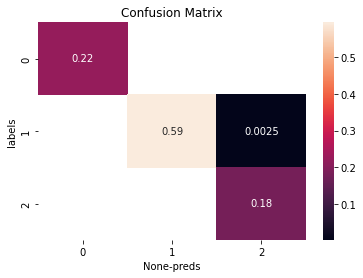

In [137]:
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('Labels')
sns.heatmap(heatmap_data, annot=True, xticklabels=[0, 1, 2])

As can be seen in the confusion matrix, the model is highly accurate with only one type of error and 0.25% of the test data falling in that error category